### Network Exploration

#### Constructing the graph

In [1]:
# Importing libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import igraph as ig

%matplotlib inline
sns.set_theme(style="whitegrid", palette="muted", font="sans-serif", font_scale=1.2)

In [2]:
# Utility function
import ast

# Need to convert the lists inside genre and movie back to lists because they are stored as strings
def convert_to_list(s):
    
    # If the value is a nan, just return a nan
    if pd.isna(s):
        return np.nan

    # Try to parse the value
    try:
        # Only parse the value if it looks like a str list
        if isinstance(s, str) and s.startswith('[') and s.endswith(']'):
            return ast.literal_eval(s)
        # In case it's something else, just return it
        else:
            return s
    # This catches cases where the list contains a nan -> [nan]
    except (ValueError, SyntaxError):
        return s

In [3]:
# Loading the data
lboxd_path = './Data/lboxd_IDcoded.csv'
augm_path = './Data/augmented_movies.csv'

lboxd = pd.read_csv(lboxd_path)
augm_movies = pd.read_csv(augm_path, index_col=0)

# Cast genre and country columns from augm_movies from strings (stored that way) back to lists
augm_movies['genre'] = augm_movies['genre'].apply(convert_to_list)
augm_movies['country'] = augm_movies['country'].apply(convert_to_list)

lboxd

,user,title,rating,movie_id
0,144,Puss in Boots: The Last Wish,4.5,66829
1,144,The Guardians of the Galaxy Holiday Special,4.0,87522
2,144,Dinosaur Hotel 2,2.0,25219
3,144,Strange World,2.5,77851
4,144,Zen - Grogu and Dust Bunnies,3.0,108598
...,...,...,...,...
1433485,290,Newark Athlete,0.0,58824
1433486,290,Roundhay Garden Scene,0.0,70149
1433487,290,Sallie Gardner at a Gallop,0.0,70959
1433488,290,This Land Is Mine,0.0,98758


In [4]:
# Getting data properties
# User nodes
users = lboxd['user'].unique()
# Movie nodes
movies = lboxd['title'].unique()
# Rating edges
edges = lboxd[['user', 'title']].values

# Making graph
G = nx.Graph()
G.add_nodes_from(users, bipartite=0)
G.add_nodes_from(movies, bipartite=1)
G.add_edges_from(edges)

In [5]:
# Checking if the graph initialization makes sense
# Check the number of nodes and edges
print(nx.number_of_nodes(G)) # seems okay
print(nx.number_of_edges(G)) # seems okay

# Get the sets of nodes
users = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
movies = {n for n, d in G.nodes(data=True) if d['bipartite'] == 1}

# Print the number of nodes in the sets
print(len(users))  # 557 is correct
print(len(movies)) # 108275 is correct

108832
1433490
557
108275


#### **Centrality** Measures
- **Degree** centrality: Find nodes with most connections.
- **Betweenness** centrality: Find nodes acting as bridges.

##### Degree Centrality
- Degree centrality is much higher in average for users than for movies.
    - Average user DC is 200x higher than movie DC -> Users have way more degrees than movies which is expected as there are 100k movies and only 557 users rating them.
- Top users: users that rated the most movies -> highly engaged in the network (highly active)
    - Average user DC is 10x lower than the top users
        - Shows that top users are far more connected than the average user -> Skewed distribution where few users are very active and most users are less active.
- Top movies: movies that were the most rated -> highly popular movies
    - Average movie DC is approximately 40x lower than the top movies
        - Shows that the top movies were rated by far more users than the average movie -> this shows a distribution where few movies are highly popular where most movies have fewer ratings (further supported by what was observed in data processing)

What we could do with this info:
- Users with high DC tend to rate more movies -> More active users, informative users in a network.
- Movies with high DC tend to be more rated (popular movies) -> Could be interesting to recommend these movies and study whether movies with high DC tend to be part of specific genres.

In [6]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)  # ran in 0.0s

In [7]:
dc_dict = dict(degree_centrality)
sorted_dc = sorted(dc_dict.items(), key=lambda i: i[1], reverse=True)

top_10_dc = sorted_dc[:10]
for node, centrality in top_10_dc:
    print(f'Node: {node}, Degree Centrality: {centrality}')

Node: 104, Degree Centrality: 0.2123475847874227
Node: 12, Degree Centrality: 0.19363049131221802
Node: 87, Degree Centrality: 0.11649254348485266
Node: 168, Degree Centrality: 0.10511710817689812
Node: 204, Degree Centrality: 0.10272808299105952
Node: 131, Degree Centrality: 0.09932831638044307
Node: 290, Degree Centrality: 0.09595611544504783
Node: 141, Degree Centrality: 0.09249202892558187
Node: 495, Degree Centrality: 0.08869715430346133
Node: 315, Degree Centrality: 0.08669404857071973


In [8]:
###
# User degree centrality analysis
# Getting the top 10 users in terms of degree centrality
print('---- Users:')
user_d_cen = {u:val for u, val in dc_dict.items() if u in users}
sorted_udc = sorted(user_d_cen.items(), key=lambda i: i[1], reverse=True)
top_10_udc = sorted_udc[:10]
for u, centrality in top_10_udc:
    print(f'User: {u}, Degree Centrality: {centrality}')

# Getting the mean degree centrality of users
mean_udc = np.mean(list(user_d_cen.values()))
print(f'---\nAverage User DC: {mean_udc}')

print('\n----------------------------------------------------------------\n')


###
# Movie degree centrality analysis
# Getting the top 10 movies in terms of degree centrality
print('---- Movies:')
movie_d_cen = {m:val for m, val in dc_dict.items() if m in movies}
sorted_mdc = sorted(movie_d_cen.items(), key=lambda i: i[1], reverse=True)
top_10_mdc = sorted_mdc[:10]
for m, centrality in top_10_mdc:
    print(f'Movie: {m}, Degree Centrality: {centrality}')

# Getting the mean degree centrality of users
mean_mdc = np.mean(list(movie_d_cen.values()))
print(f'---\nAverage Movie DC: {mean_mdc}')


---- Users:
User: 104, Degree Centrality: 0.2123475847874227
User: 12, Degree Centrality: 0.19363049131221802
User: 87, Degree Centrality: 0.11649254348485266
User: 168, Degree Centrality: 0.10511710817689812
User: 204, Degree Centrality: 0.10272808299105952
User: 131, Degree Centrality: 0.09932831638044307
User: 290, Degree Centrality: 0.09595611544504783
User: 141, Degree Centrality: 0.09249202892558187
User: 495, Degree Centrality: 0.08869715430346133
User: 315, Degree Centrality: 0.08669404857071973
---
Average User DC: 0.023647588134565432

----------------------------------------------------------------

---- Movies:
Movie: Get Out, Degree Centrality: 0.004676976229199401
Movie: Parasite, Degree Centrality: 0.004667787670792329
Movie: Knives Out, Degree Centrality: 0.004658599112385258
Movie: Lady Bird, Degree Centrality: 0.004410508035394327
Movie: The Social Network, Degree Centrality: 0.004401319476987255
Movie: Gone Girl, Degree Centrality: 0.0043921309185801834
Movie: Midsom

In [9]:
# Print augmented values from top 10 BC movies

top_10_mdc_names = [mbc[0] for mbc in top_10_mdc]
top_10_mdc_movies = augm_movies[augm_movies['name'].isin(top_10_mdc_names)]
top_10_mdc_movies

,name,date,minute,mean_rating,genre,country
33194,Get Out,2017.0,104.0,4.16,"[Horror, Mystery, Thriller]",[USA]
34196,Gone Girl,2014.0,149.0,4.07,"[Drama, Thriller, Mystery]",[USA]
45710,Knives Out,2019.0,131.0,4.00,"[Mystery, Comedy, Crime]",[USA]
46634,Lady Bird,2017.0,94.0,3.86,"[Comedy, Drama]",[USA]
53735,Midsommar,2019.0,147.0,3.78,"[Mystery, Drama, Horror]","[Sweden, USA]"
60365,Once Upon a Time… in Hollywood,2019.0,162.0,3.76,"[Drama, Comedy, Thriller]","[USA, UK, China]"
62189,Parasite,2019.0,133.0,4.57,"[Comedy, Thriller, Drama]",[South Korea]
71017,Scream,1996.0,112.0,4.02,"[Mystery, Crime, Horror]",[USA]
83413,The Dark Knight,2008.0,152.0,4.46,"[Thriller, Crime, Action, Drama]","[UK, USA]"
94200,The Social Network,2010.0,121.0,3.96,[Drama],[USA]


In [10]:
augm_counts_mdc = {
    'genres': [],
    'countries': []
}

for i, row in top_10_mdc_movies.iterrows():

    genres = row['genre']
    for g in genres: augm_counts_mdc['genres'].append(g)
    
    countries = row['country']
    for c in countries: augm_counts_mdc['countries'].append(c)

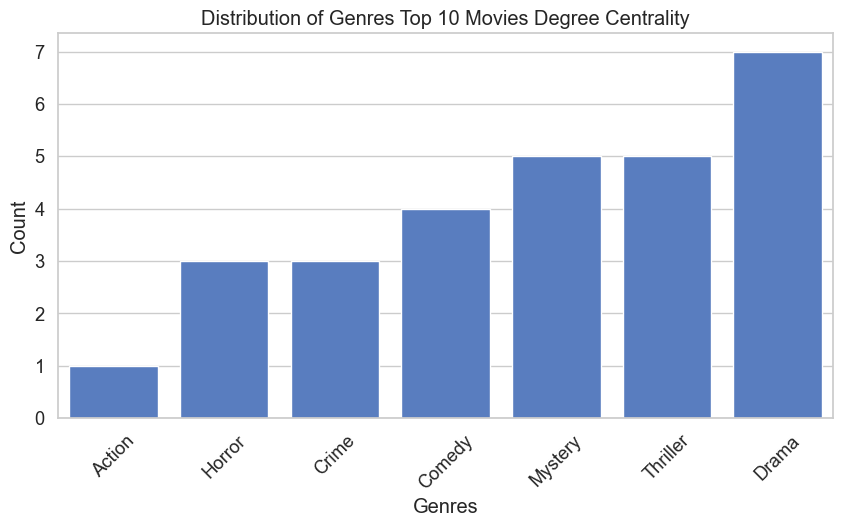

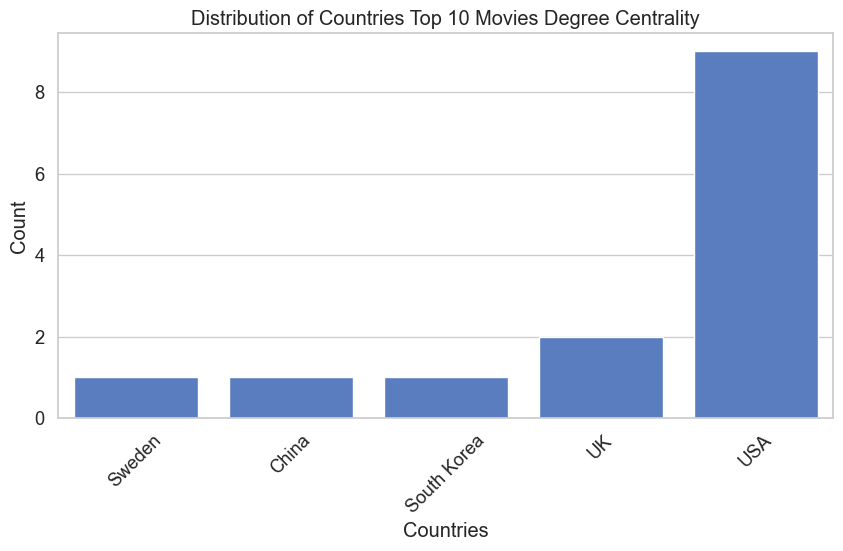

In [15]:
from collections import Counter

# Count occurrences of each genre and sort by genre name
genre_counts_mdc = dict(Counter(augm_counts_mdc['genres']))
sorted_genres_mdc = sorted(genre_counts_mdc.items(), key=lambda x: x[1])

# Count occurrences of each country and sort by country name
country_counts_mdc = dict(Counter(augm_counts_mdc['countries']))
sorted_countries_mdc = sorted(country_counts_mdc.items(), key=lambda x: x[1])

# Separate keys and values for plotting
genres_mdc, genre_counts_mdc = zip(*sorted_genres_mdc)
countries_mdc, country_counts_mdc = zip(*sorted_countries_mdc)

# Create the genre histogram
plt.figure(figsize=(10, 5))
sns.barplot(x=list(genres_mdc), y=list(genre_counts_mdc))
plt.title('Distribution of Genres Top 10 Movies Degree Centrality')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Create the country histogram
plt.figure(figsize=(10, 5))
sns.barplot(x=list(countries_mdc), y=list(country_counts_mdc))
plt.title('Distribution of Countries Top 10 Movies Degree Centrality')
plt.xlabel('Countries')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


##### Betweenness Centrality
Users with high betweenness centrality are pivotal in the network, bridging different groups of users and movies. These users can influence the flow of information and recommendations within the network. Similarly, movies with higher betweenness centrality are important connectors within the movie-user network.
- Betweenness centrality is much higher in average for users than for movies.
    - Users play a more important (central) role in bridging different parts of the network.
- Top users: 
    - Users with high BC are important for the flow of information in the network, they connect isolated parts of the network and act as bridges between clusters of users and movies.
    - Average user BC is 40x lower than the top users
        - Network as few users that play a critical role in connecting the isolated parts of the graph while most users have a lower bridging effect.
    - The users with high BC are likely to be influencial and good points to start information diffusion.
- Top movies: 
    - Movies having a high BC, are important in connecting diverse groups of users together. They may have been rated by a diverse range of users which indicates their appeal to large heterogeneous populations.
    - Average movie BC is approximately 90x lower than the top movies
        - As usual, the network is composed of few movies that act as bridges to diverse groups of users while most movies are more niche.
    - Top BC movies might be useful for increasing engagement for users with low activity (due to their high appeal) and can also help connect diverse groups of users together (can help learn what is liked by diverse audiences)

What we could do with this info:
- Users: detect influencial users and target them with strategies for recommendations and spreading info of movies.
- Movies: detect movies that are central and liked by diverse audiences to: 1) promote those movies to ppl having not watched them. 2) study the properties of those movies to understand what makes a movie being watched by diverse users.

In [7]:
# Calculate betweenness_centrality
# the normal betweenness networkx function on the full dataset takes too long to run -> didn't terminate after an hour
# betweenness_centrality = nx.betweenness_centrality(G)

# Testing with igraph instead
g = ig.Graph.from_networkx(G)

b_cen_raw = g.betweenness(directed=False)  # ran in 22m59.7s

# Adding normalization factor myself because igraph doesn't implement it in their method
n = len(g.vs)
if g.is_directed():
    normalization_factor = (n - 1) * (n - 2)
else:
    normalization_factor = (n - 1) * (n - 2) / 2

b_cen = [b / normalization_factor for b in b_cen_raw]

In [8]:
# Get the list of nodes from the original NetworkX graph
nodes = list(G.nodes())

# Create a dictionary mapping nodes to their betweenness centrality
betweenness_dict = dict(zip(nodes, b_cen))
#betweenness_dict

In [9]:
sorted_bc = sorted(betweenness_dict.items(), key=lambda i: i[1], reverse=True)

top_10_bc = sorted_bc[:10]
for node, centrality in top_10_bc:
    print(f'Node: {node}, Betweenness Centrality: {centrality}')

Node: 104, Betweenness Centrality: 0.13458819821781723
Node: 12, Betweenness Centrality: 0.10903536583626044
Node: 204, Betweenness Centrality: 0.07238848630367709
Node: 87, Betweenness Centrality: 0.05432885897427086
Node: 315, Betweenness Centrality: 0.04128666509525295
Node: 131, Betweenness Centrality: 0.03289900011918988
Node: 509, Betweenness Centrality: 0.029110295415565954
Node: 301, Betweenness Centrality: 0.027658090021256534
Node: 136, Betweenness Centrality: 0.025889866403294486
Node: 168, Betweenness Centrality: 0.022894984876677876


In [10]:
###
# User betweenness analysis
# Getting the top 10 users in terms of betweenness centrality
print('---- Users:')
user_b_cen = {u:val for u, val in betweenness_dict.items() if u in users}
sorted_ubc = sorted(user_b_cen.items(), key=lambda i: i[1], reverse=True)
top_10_ubc = sorted_ubc[:10]
for u, centrality in top_10_ubc:
    print(f'User: {u}, Betweenness Centrality: {centrality}')

# Getting the mean betweenness centrality of users
mean_ubc = np.mean(list(user_b_cen.values()))
print(f'---\nAverage User BC: {mean_ubc}')

print('\n----------------------------------------------------------------\n')


###
# Movie betweenness analysis
# Getting the top 10 movies in terms of betweenness centrality
print('---- Movies:')
movie_b_cen = {m:val for m, val in betweenness_dict.items() if m in movies}
sorted_mbc = sorted(movie_b_cen.items(), key=lambda i: i[1], reverse=True)
top_10_mbc = sorted_mbc[:10]
for m, centrality in top_10_mbc:
    print(f'Movie: {m}, Betweenness Centrality: {centrality}')

# Getting the mean betweenness centrality of users
mean_mbc = np.mean(list(movie_b_cen.values()))
print(f'---\nAverage Movie BC: {mean_mbc}')


---- Users:
User: 104, Betweenness Centrality: 0.13458819821781723
User: 12, Betweenness Centrality: 0.10903536583626044
User: 204, Betweenness Centrality: 0.07238848630367709
User: 87, Betweenness Centrality: 0.05432885897427086
User: 315, Betweenness Centrality: 0.04128666509525295
User: 131, Betweenness Centrality: 0.03289900011918988
User: 509, Betweenness Centrality: 0.029110295415565954
User: 301, Betweenness Centrality: 0.027658090021256534
User: 136, Betweenness Centrality: 0.025889866403294486
User: 168, Betweenness Centrality: 0.022894984876677876
---
Average User BC: 0.0032484874012606987

----------------------------------------------------------------

---- Movies:
Movie: Get Out, Betweenness Centrality: 0.0006172986940887112
Movie: Parasite, Betweenness Centrality: 0.0006084787437892438
Movie: Scream, Betweenness Centrality: 0.000595259353663621
Movie: Knives Out, Betweenness Centrality: 0.0005898394437044395
Movie: Pulp Fiction, Betweenness Centrality: 0.0005877140613168

In [11]:
# Print augmented values from top 10 BC movies

top_10_mbc_names = [mbc[0] for mbc in top_10_mbc]
top_10_mbc_movies = augm_movies[augm_movies['name'].isin(top_10_mbc_names)]
top_10_mbc_movies

,name,date,minute,mean_rating,genre,country
33194,Get Out,2017.0,104.0,4.16,"[Horror, Mystery, Thriller]",[USA]
35505,Halloween,1978.0,91.0,3.81,"[Horror, Thriller]",[USA]
37925,Home Alone,1990.0,103.0,3.79,"[Family, Comedy]",[USA]
42827,Jaws,1975.0,124.0,3.98,"[Adventure, Thriller, Horror]",[USA]
45710,Knives Out,2019.0,131.0,4.00,"[Mystery, Comedy, Crime]",[USA]
60365,Once Upon a Time… in Hollywood,2019.0,162.0,3.76,"[Drama, Comedy, Thriller]","[USA, UK, China]"
62189,Parasite,2019.0,133.0,4.57,"[Comedy, Thriller, Drama]",[South Korea]
65649,Pulp Fiction,1994.0,154.0,4.27,"[Crime, Thriller]",[USA]
71017,Scream,1996.0,112.0,4.02,"[Mystery, Crime, Horror]",[USA]
93790,The Shining,1980.0,144.0,4.25,"[Horror, Thriller]","[UK, USA]"


In [12]:
augm_counts_mbc = {
    'genres': [],
    'countries': []
}

for i, row in top_10_mbc_movies.iterrows():

    genres = row['genre']
    for g in genres: augm_counts_mbc['genres'].append(g)
    
    countries = row['country']
    for c in countries: augm_counts_mbc['countries'].append(c)

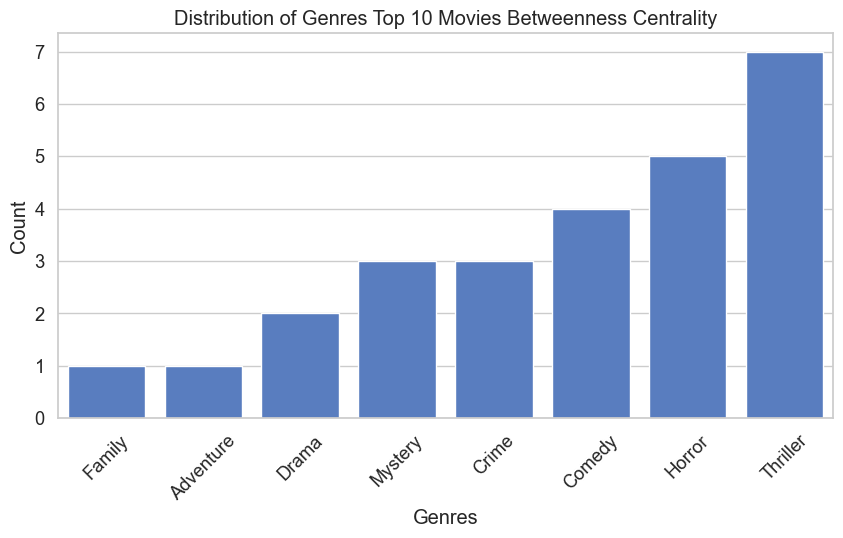

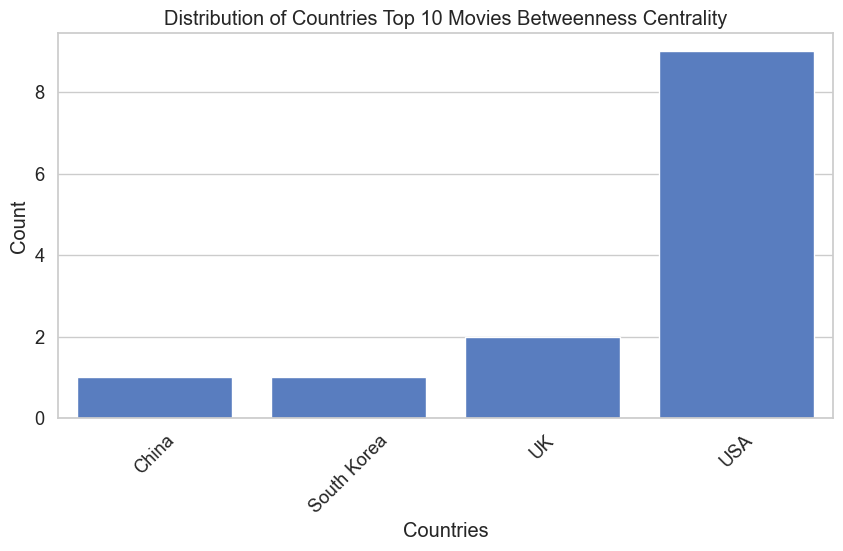

In [13]:
from collections import Counter

# Count occurrences of each genre and sort by genre name
genre_counts_mbc = dict(Counter(augm_counts_mbc['genres']))
sorted_genres_mbc = sorted(genre_counts_mbc.items(), key=lambda x: x[1])

# Count occurrences of each country and sort by country name
country_counts_mbc = dict(Counter(augm_counts_mbc['countries']))
sorted_countries_mbc = sorted(country_counts_mbc.items(), key=lambda x: x[1])

# Separate keys and values for plotting
genres_mbc, genre_counts_mbc = zip(*sorted_genres_mbc)
countries_mbc, country_counts_mbc = zip(*sorted_countries_mbc)

# Create the genre histogram
plt.figure(figsize=(10, 5))
sns.barplot(x=list(genres_mbc), y=list(genre_counts_mbc))
plt.title('Distribution of Genres Top 10 Movies Betweenness Centrality')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Create the country histogram
plt.figure(figsize=(10, 5))
sns.barplot(x=list(countries_mbc), y=list(country_counts_mbc))
plt.title('Distribution of Countries Top 10 Movies Betweenness Centrality')
plt.xlabel('Countries')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
